Import Data

In [0]:
# imports
import io
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
from collections import defaultdict
from IPython.display import display
from scipy.spatial.distance import pdist, squareform
np.set_printoptions(threshold=sys.maxsize)

In [0]:
# mount google drive
def mount():
  drive.mount('/content/gdrive')

In [0]:
# upload file
def upload():
  uploaded = files.upload()
  return uploaded

In [0]:
# read csv file
def read_csv(uploaded):
  data = pd.read_csv(io.BytesIO(uploaded['user_launches_appAnon.csv']))
  return data

Sort Data

In [0]:
# sort data by user id and app id
def sort_data(data):
  user_sorted = data.sort_values(["userID", "appID"], ascending=[True, True])
  user_sorted.head()
  return data

Number of unique and actual list of unique values in each column

In [0]:
# get number of and actual list of unique values in each column
def unique_apps_users(user_sorted):
  user_sorted["userID"].value_counts() #10,368
  user_sorted["appID"].value_counts() # 45,788

  unique_apps = user_sorted["appID"].unique()
  unique_apps.sort()

  unique_users = user_sorted["userID"].unique()
  unique_users.sort()

  return unique_apps, unique_users

Get Features

In [0]:
# get features of the raw data
def show_sorted(user_sorted):
  print("User sorted features: ")
  display(user_sorted.describe())
  #display(user_sorted.boxplot())
  #display(user_sorted.plot.hist())

Create dict of users and apps

In [0]:
# iterate through each row and add each occurrence to dictionary, this will return a dict
# that has each user with the list of apps they have used
def get_user_apps(user_sorted):
  user_apps = defaultdict(list)

  for index, row in user_sorted.iterrows():
    user_apps[row["userID"]].append(row["appID"])

  user_apps = dict(user_apps)

  print("User apps: ", user_apps)
  print(" ")
  return user_apps

Create dict of apps and users

In [0]:
# iterate through each row and add each occurrence to dictionary, this will return a dict
# that has each app with the list users that have used it
# currently keys not in order
def get_app_users(user_sorted):
  app_users = defaultdict(list)

  for index, row in user_sorted.iterrows():
    app_users[row["appID"]].append(row["userID"])

  app_users = dict(app_users)

  print("App users: ", app_users)
  print(" ")
  return app_users

Code for mapping dict to dataframe

In [0]:
#create a sparse data frame showing whether each user has used an app before
def create_df(user_apps, unique_apps, unique_users):
  user_apps_DF = pd.DataFrame(columns=unique_apps, index=unique_users)
  user_apps_DF = user_apps_DF.fillna(0)

  for key, value in user_apps.items():
    for entry in value:
      user_apps_DF.at[key, entry] = 1

  #user_apps_DF.sort_index(axis=0, inplace=True)
  return user_apps_DF

Saving Dataframe (only need when new columns are added)

In [0]:
# convert dataframe to csv 
def convert_to_csv(user_apps_DF):
  user_apps_DF.to_csv('sparse_dataframe.csv')

Get counts of each app, convert to dataframe


In [0]:
# there are 10367 users that do not use app 259
# user_apps_DF[259].value_counts()[0]

In [0]:
# iterate through each app and count how many occurences there are where a 1 is in its column
def get_app_counts(user_apps_DF, unique_apps):

  app_counts = {}

  for entry in unique_apps:
    app_counts[entry] = user_apps_DF[entry].value_counts()[1]

  print("App counts: ", app_counts)
  print(" ")

  return app_counts

In [0]:
# convert app counts to a dataframe (need to change column names and reset index to make it readable)
def convert_counts_to_df(app_counts):
  app_counts_DF = pd.DataFrame(list(app_counts.items()), columns=['appID', 'count'])
  app_counts_DF.sort_values('count', ascending=False, inplace=True)
  app_counts_DF.reset_index(drop=True, inplace=True)

  print("App counts")
  display(app_counts_DF)
  print(" ")

  return app_counts_DF

Show app counts

In [0]:
def show_app_counts_boxplot(app_counts_DF):
  print("App counts boxplot: ")
  display(app_counts_DF.boxplot())
  #sns.boxplot(x='appID', y='count', data=app_counts_DF)

In [0]:
def show_app_counts_scatter(app_counts_DF, num):
  print("App counts scatter: ")
  sns.regplot(x='appID', y='count', data=app_counts_DF.iloc[:num], fit_reg=False)

In [0]:
def show_app_counts_bar(app_counts_DF, num):
  print("App counts bar graph: ")
  sns.barplot(x='appID', y='count', data=app_counts_DF.iloc[:num], order=app_counts_DF.iloc[:num]['appID'])

Group apps by count

In [0]:
# group apps together by their counts, showing how many instances there are of each count occurence
def group_apps(app_counts_DF):
  grouped_apps = app_counts_DF.groupby(['count']).count()
  grouped_apps.reset_index(inplace=True)
  grouped_apps.rename(columns={'count':'user_count', 'appID':'count'}, inplace=True)

  return grouped_apps

In [0]:
# show grouped apps
def show_grouped_apps(grouped_apps):
  #grouped_apps['count'].iloc[50:].sum()
  print("Grouped apps bar graph: ")
  display(grouped_apps.iloc[50:].plot.bar(x='user_count', y='count'))

Main Functions

In [0]:
# setup functions to import and save data
def setup():
  uploaded = upload()
  data = read_csv(uploaded)

  return data

In [0]:
# main functions to sort and analyse data
def main(data):
  user_sorted = sort_data(data)
  #show_sorted(user_sorted)
  unique_apps, unique_users = unique_apps_users(user_sorted)
  user_apps = get_user_apps(user_sorted)
  app_users = get_app_users(user_sorted)
  user_apps_DF = create_df(user_apps, unique_apps, unique_users)
  #convert_to_csv(user_apps_DF)
  app_counts = get_app_counts(user_apps_DF, unique_apps)
  app_counts_DF = convert_counts_to_df(app_counts)
  grouped_apps = group_apps(app_counts_DF)

  return app_counts_DF, user_apps_DF, grouped_apps, unique_apps, unique_users

In [24]:
# call funtions 
data = setup()
app_counts_DF, user_apps_DF, grouped_apps, unique_apps, unique_users = main(data)

Saving user_launches_appAnon.csv to user_launches_appAnon (1).csv
User apps:  {177: [1, 878, 879, 2145, 2259, 2296, 2573, 2594, 2634, 2667, 2766, 2830, 3201, 3389, 3581, 3818, 3909, 3911, 3912, 3923, 3929, 3930, 3937, 3939, 3942, 3945, 3946, 3948, 3949, 3950, 3952, 3953, 3954, 3956, 3958, 3964, 3965, 3968, 3969, 3972, 3973, 3976, 3980, 3981, 3983, 3989, 3991, 4186, 4823, 4833, 4892, 5259, 5344, 5412, 5452, 5553, 5581, 5644, 5660, 6112, 6113, 6242, 6295, 6321, 6379, 6439, 6509, 6593, 7092, 7227, 7415, 7461, 7896, 8004, 8046, 8423, 8444, 8554, 8706, 8725, 8876, 8878, 8919, 8981, 9223, 9372, 9388, 9462, 9823, 9964, 10096, 10351, 10357, 10365, 10371, 10543, 10545, 11121, 11155, 11249, 11334, 11339, 11489, 11559, 11641, 12020, 12303, 12309, 12312, 12364, 12496, 12598, 12772, 12773, 12789, 12868, 12871, 12876, 13142, 13272, 14033, 14068, 14190, 14345, 14432, 14550, 14637, 14649, 14655, 14663, 14666, 14667, 14670, 14676, 14682, 14688, 14708, 14805, 14886, 14995, 15016, 15308, 15383, 15439, 15

appID  count
0      31336  10173
1       3980   9586
2       3969   6452
3       3950   5207
4      28804   4952
...      ...    ...
45783  25427      1
45784  25426      1
45785  25424      1
45786   9468      1
45787  45788      1

[45788 rows x 2 columns]

Show app counts graphs

App counts boxplot: 


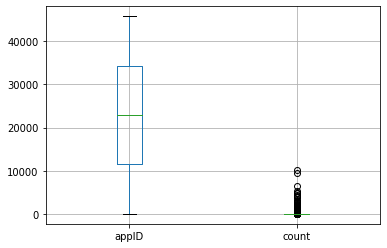

In [39]:
show_app_counts_boxplot(app_counts_DF)

App counts scatter: 


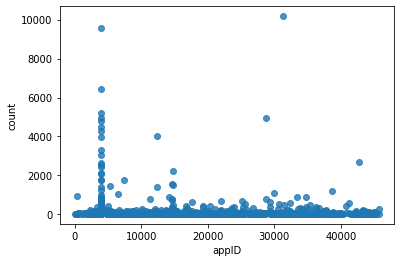

In [40]:
show_app_counts_scatter(app_counts_DF, 1000)

App counts bar graph: 


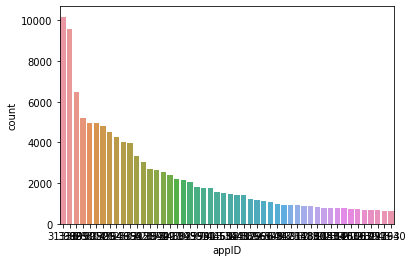

In [29]:
show_app_counts_bar(app_counts_DF, 50)

In [0]:
# don't actually know what this shows
sns.kdeplot(app_counts_DF.iloc[:50]['appID'], app_counts_DF.iloc[:50]['count'])

In [0]:
# also don't actually know what this shows
sns.clustermap(app_counts_DF.iloc[:100])

Create dataframes with top apps and calculate hamming distances

In [0]:
# Create data with the top 100, 300 and 500 apps only
user_top_1_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[1:], axis=1)
user_top_5_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[5:], axis=1)
user_top_10_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[10:], axis=1)
user_top_50_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[50:], axis=1)
user_top_100_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[100:], axis=1)
user_top_300_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[300:], axis=1)
user_top_500_apps_DF = user_apps_DF.drop(app_counts_DF['appID'].iloc[500:], axis=1)

In [0]:
# this calculates the normalised hamming distance, or the proportion of elements which disagree between the rows (ie. are different)
# values get smaller as more apps are compared as more values are zero therefore the proportion of differences is less
def hamming_distance(df):
  distance = pdist(df.values, metric='hamming')
  dist_matrix = squareform(distance)
  distance_DF = pd.DataFrame(dist_matrix, columns=unique_users, index=unique_users)

  return distance_DF

In [80]:
distance_DF = hamming_distance(user_top_100_apps_DF)
distance_DF

2      4      5      6      7      ...  16186  16189  16191  16193  16194
2       0.00   0.18   0.18   0.18   0.14  ...   0.11   0.16   0.15   0.17   0.45
4       0.18   0.00   0.10   0.10   0.12  ...   0.17   0.14   0.13   0.09   0.55
5       0.18   0.10   0.00   0.06   0.08  ...   0.15   0.10   0.15   0.05   0.57
6       0.18   0.10   0.06   0.00   0.04  ...   0.15   0.16   0.15   0.01   0.63
7       0.14   0.12   0.08   0.04   0.00  ...   0.13   0.16   0.15   0.03   0.59
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
16186   0.11   0.17   0.15   0.15   0.13  ...   0.00   0.17   0.16   0.14   0.48
16189   0.16   0.14   0.10   0.16   0.16  ...   0.17   0.00   0.13   0.15   0.49
16191   0.15   0.13   0.15   0.15   0.15  ...   0.16   0.13   0.00   0.14   0.50
16193   0.17   0.09   0.05   0.01   0.03  ...   0.14   0.15   0.14   0.00   0.62
16194   0.45   0.55   0.57   0.63   0.59  ...   0.48   0.49   0.50   0.62   0.00

[10368 rows x 10368 columns]

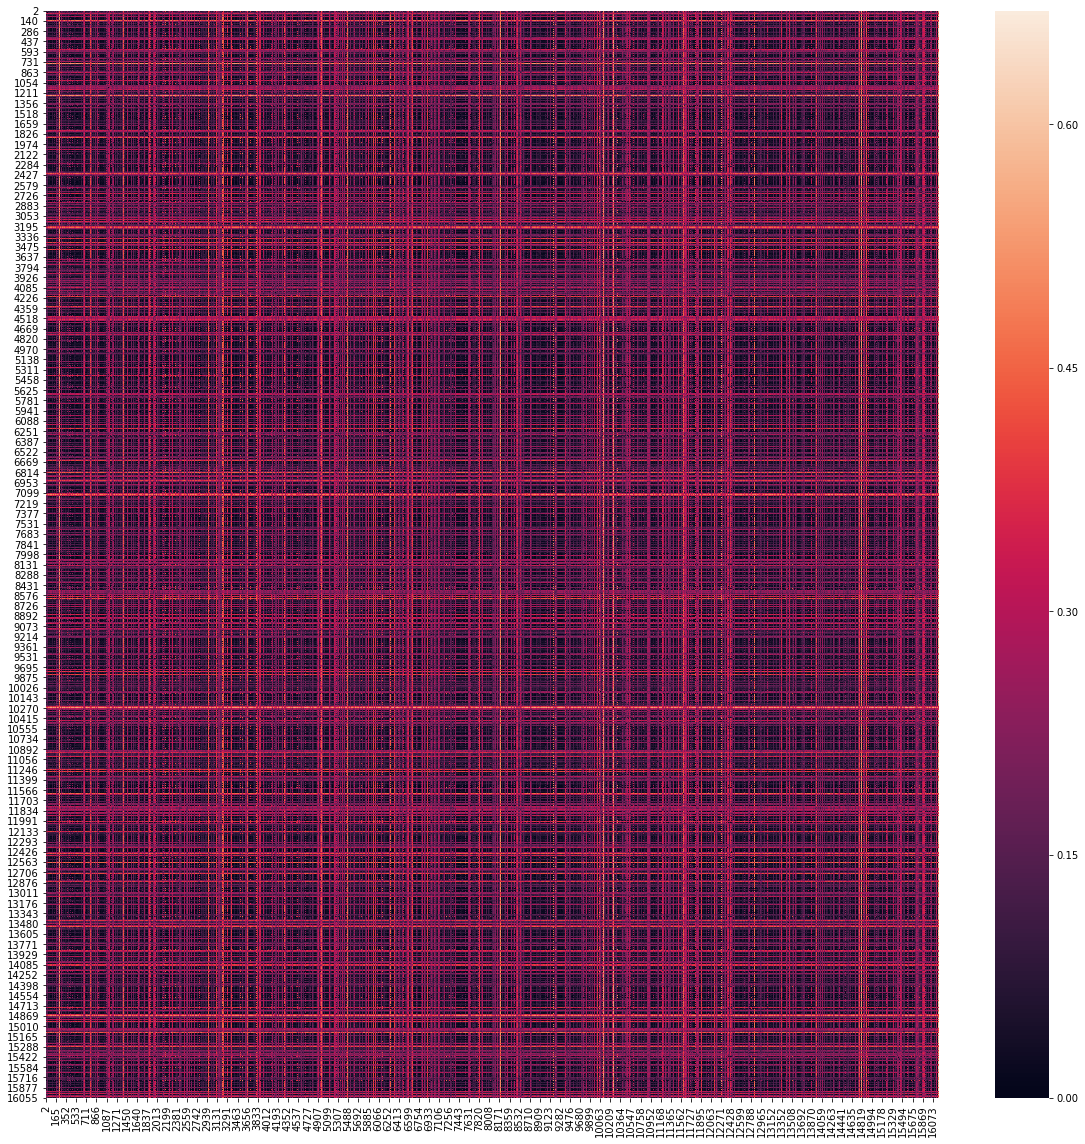

In [79]:
# a lot of data, next step is to filter out useless users from other data sets
plt.subplots(figsize=(20,20))
sns.heatmap(distance_DF)